# Health Survey Data Analysis

Phillip Jerome Allen

## Executive Summary

In this project I will be cleaning data and performing inferential statistics on a subset of data collected by the CDC Behavioral Risk Factor Surveillance System (BRFSS) from 2020-2021 in the state of New York.

Goals of the project:
- Clean the data by removing unecessary columns and records.
- Calculate the confidence interval for the PHYSHLTH mean
- Describe the statistical differences between home owners and renters in regards to their physical health
- Perform a t-Test
- Describe the next steps

## The Data

Simply speaking, the CDC collected data asking those surveyed among other questions, the following:
- The State they live in
- The number of days they experience poor physical health in the past 30 days
- And whether they rent or own the home they live in.
    
**Summary on the data used:**
- The data presented below will include records collected from 2020-2021 and in the state of New York.
- This project will focus on two columns of the available data, `PHYSHLTH` and `RENTHOM1`.
    - `PHYSHLTH` represents the number of days the individual surveyed reported having experienced poor physical health in the last 30 days
        - There are other values other than 0 - 30
        - However, they are are codes for other answers given, so we will not be including records that show these values.
    - `RENTHOM1` represents the whether the individual surveyed owns (1) or rents (2) their home
        - Similar to `PHYSHLTH`, there are codified values other 1 or 2, and will have said records removed.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as stats
import math
import warnings
warnings.filterwarnings('ignore')



file_path = "https://raw.githubusercontent.com/learn-co-curriculum/da-phase3-project-enterprise/main/brfss_ny.csv"
df = pd.read_csv(file_path)

## Data Preparation

TODO: write an explanation of the data preparation/cleaning steps you are about to perform using Markdown

In [2]:
# Remove unecessary colums and keep only PHYSHLTH and RENTHOM1
df = df[['PHYSHLTH','RENTHOM1']]

# Check if there are any NaN values in PHYSHLTH or RENTHOM1
print(df['PHYSHLTH'].isnull().values.any())
print(df['RENTHOM1'].isnull().values.any())

False
False


In [3]:
# TODO: write code to prepare the PHYSHLTH column

# Converting all instances of 88 to 0
df.PHYSHLTH = np.where(df['PHYSHLTH'] == 88, 0, df['PHYSHLTH'])

# Dropping all records where PHYSHLTH is 77, 99
df = df.drop(df[df.PHYSHLTH == 77].index)
df = df.drop(df[df.PHYSHLTH == 99].index)
df = df.dropna(subset=['PHYSHLTH'])

In [4]:
# TODO: write code to prepare the RENTHOM1 column
# Drop all records with values of RENTHOM1 other than 1 or 2.
df = df.drop(df[df.RENTHOM1 > 2].index)

## Confidence Interval for Mean of `PHYSHLTH`

In [5]:
x_bar = np.mean(df.PHYSHLTH)
n = len(df.PHYSHLTH)
s = np.std(df.PHYSHLTH, ddof=1)
se = s / math.sqrt(n)

print(x_bar, s, n)
print()
print("The Sample Mean:")
print(x_bar)
print("The Sample Standard Deviation:")
print(s)

stats.t.interval(alpha = 0.95,                # Confidence Level
                 df = n-1,                    # Degrees of Freedom
                 loc = x_bar,                 # Sample mean
                 scale = se)                  # Standard error

3.064646020938575 7.581325164851767 13659

The Sample Mean:
3.064646020938575
The Sample Standard Deviation:
7.581325164851767


(2.9374942974789575, 3.1917977443981926)

**Confidence Interval Interpretation**

Based on the data collected between the years 2020-2021 and considering a 95% confidence interval; New Yorkers experienced 2.9 - 3.2 days of poor physical health in the 30 days prior to taking part of the survey.

## Differences in `PHYSHLTH` Based on `RENTHOM1`

### How Does `PHYSHLTH` Differ Based on `RENTHOM1`?

By splitting the data by `RENTHOM1` (which tells us whether or not those surveyed own or rent their homes) we can determine whether or not home ownership (and the variables that determine this category) have any statistical significance towards the physical health of those surveyed.

In [6]:
# TODO: write code to separate the records based on the value of RENTHOM1

# DataFrame of individuals who took the survey and own their home
df_own = df.drop(df[df.RENTHOM1 == 2].index)

# DataFrame of individuals who took the survey and rent their home
df_rent = df.drop(df[df.RENTHOM1 == 1].index)

In [7]:
# Create a variables for comparing the means later
own_mean = df_own.PHYSHLTH.mean()
rent_mean = df_rent.PHYSHLTH.mean()

# Compare the Means
print(own_mean)
print(rent_mean)

2.675854726132734
3.6959277756434883


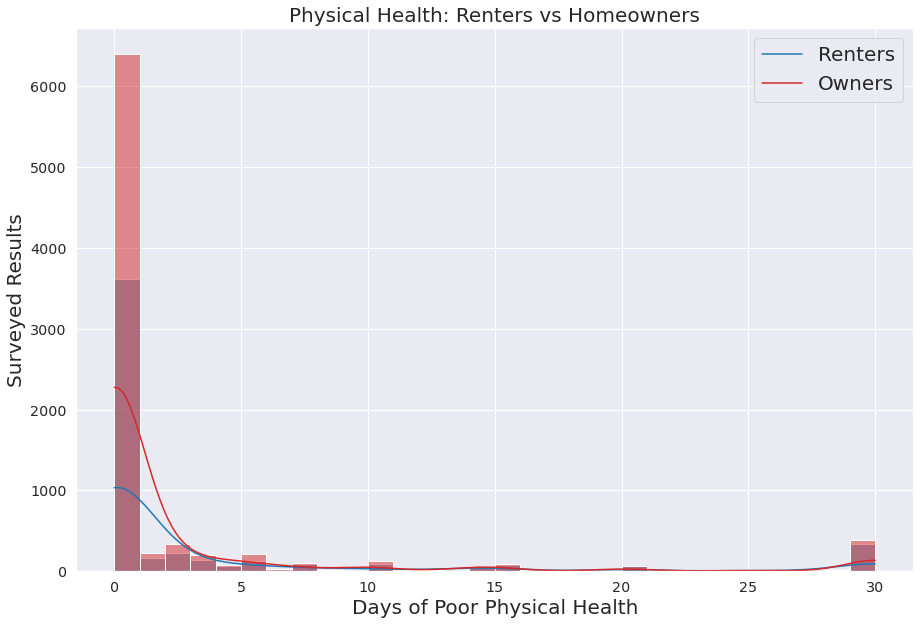

In [8]:
# TODO: write code to produce one or more plots that show the value of
# PHYSHLTH based on the value of RENTHOM1
sns.set(font_scale=1.3)
plt.figure(figsize=(15,10))
p = sns.histplot(data=df, 
                 x="PHYSHLTH", 
                 bins=30, 
                 hue="RENTHOM1", 
                 kde=True, 
                 palette=['tab:red','tab:blue'])
p.set_xlabel('Days of Poor Physical Health', 
             fontsize=20)
p.set_ylabel('Surveyed Results', 
             fontsize=20)
p.set_title("Physical Health: Renters vs Homeowners", 
            fontsize=20)
p.legend(labels=['Renters','Owners'], 
         fontsize = 20);

The plot above shows us:
**Based on the available data:**
- For both Home owners and renters there is a peak at 0 days of poor physical health and a slight peak at 30 days.
- Home owners are generally twice as likely to not suffer from poor physical health than renters.
- When home owners are suffering from poor physical health they tend to do so more frequently than home renters.
- Home renters seem to report suffering 20-25 poor physical health days more so than their home owner counterparts.
- There is a spike of 30 reported poor physical health days for both home owners and renters, although home owners report more frequently by a small margin.

### Is the Difference Statistically Significant?

**Consideration:**
- alpha = 0.05

**Hypothesis:**
- H0 = Homeownership doesn't influence improved physical health of New Yorkers.
- H1 = Homeownership influences improved physical health of New Yorkers.

**Test Performed:**
- Due to the means being only roughly 1 day apart, I'll be performing a one-tailed Welch's t-test.

In [14]:
# TODO: write code to calculate the test statistic and p-value for a t-test

#Function to calculate the t-stats for two samples
def welch_t(a, b):
    numerator = a.mean() - b.mean()
    denominator = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)
    return np.abs(numerator/denominator)

# Function to calculate the degrees of freedom for two samples
def welch_def(a,b):
    s1 = a.var(ddof=1)
    s2 = b.var(ddof=1)
    n1 = a.size
    n2 = b.size
    
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/n1)**2/(n1 -1) + (s2/n2)**2/(n2 - 1)
        
    return numerator / denominator

# Perform Tests
t_tests = welch_t(df_own.PHYSHLTH, df_rent.PHYSHLTH)
deg_f = welch_def(df_own.PHYSHLTH, df_rent.PHYSHLTH)
print(t_tests, deg_f)

# Determine p-value
p_val = 1 - stats.t.cdf(t_tests, deg_f)
print(p_val)

7.388322797834585 9789.779480096699
8.049116928532385e-14


Due to the p-value being lower than 0.05 we can reject the null hypothesis. 

Therefore, **based on the data collected we can assume that homeownership has an influence on the physical health of New Yorkers.**

## Next Steps
Considering the resources available on the CDC codebook, I would propose investigating is:
- **IMONTH**: I believe that the month of the interview can have a significant effect on the results of the survey since, even before the years of 2020-2021, one could see spikes in poor physical health in certain months of year due to flu-season and changing seasons.
- Either way, it would be interesting to see if months where outbreaks in COVID would spike would have a significant effect on the results.